# Prueba modelo CycleGAN

En este notebook se pretende poner a prueba el modelo de red generativa adversaria conocido como CycleGAN, capaz de generar nuevas imágenes a partir de otras, de forma no supervisada.

Concretamente, se tratará de generar, a partir de imágenes de caras de personas reales, una imagen con un estilo caricaturizado (y el contrario).
Para entrenar al modelo, contaremos con dos datasets, donde el primero contendrá imágenes correspondientes a personas reales, mientras que el segundo contará con imágenes de caricaturas que comparten similar estilo.


## Importaciones


Primero, se instalará el paquete tensorflow_examples, el cual nos permitirá importar el generador y el discriminador usado en el modelo Pix2Pix:

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-4fbfmtuy
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-4fbfmtuy


A continuación, importamos todas las librerías que sean necesarias, y creamos la variable AUTOTUNE, la cual nos servirá de apoyo para usar los conjuntos de entrenamiento y de prueba:

In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
%tensorflow_version 2.x

## Conjuntos de datos

Comenzamos definiendo las rutas donde se albergan los dataset, así como la cantidad de datos que deseamos utilizar:

In [5]:
# Ruta raíz
PATH = "/content/drive/MyDrive"

# Ruta datos caras reales
RF_PATH = PATH + "/Dataset/FaceDataset"
# Ruta datos caricaturas
CRT_PATH = PATH + "/Dataset/CartoonDataset"

# Ruta checkpoint
CKPATH = PATH + "/checkpoint"

# Cantidad de datos
RF_N = 2000
CRT_N = 2000

Creamos la partición de conjuntos de entrenamiento/prueba:

In [6]:
# Listado de archivos de caras reales
rf_imgurls = ["{:06}.jpg".format(i+1) for i in range(RF_N)]
# Listado de archivos de caricaturas
crt_imgurls = ["{}.png".format(i+1) for i in range(CRT_N)]

# Reordenado aleatorio de las listas
rng_rf_imgurls = np.copy(rf_imgurls)
np.random.shuffle(rng_rf_imgurls)

rng_crt_imgurls = np.copy(crt_imgurls)
np.random.shuffle(rng_crt_imgurls)

# Partición conjuntos entrenamiento/prueba
ratio = 0.8 # 80% entrenamiento, 20% prueba

train_rf_imgurls = rng_rf_imgurls[:round(ratio*RF_N)]
test_rf_imgurls = rng_rf_imgurls[round(ratio*RF_N):RF_N]

train_crt_imgurls = rng_crt_imgurls[:round(ratio*CRT_N)]
test_crt_imgurls = rng_crt_imgurls[round(ratio*CRT_N):CRT_N]

Aplicamos recorte y jittering aleatorios a cada imagen:

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [8]:
# Funciones de preprocesado de imágenes

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image


# normalizar imagen al rango [-1, 1]
def normalize(image):
  #image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image


def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image


def preprocess_image(filename, rf=True, train=True):
  if rf:
    path = RF_PATH
  else:
    path = CRT_PATH
  
  image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(path + '/' + filename)), tf.float32)[..., :3]

  if train:
    image = random_jitter(image)
  else:
    image = tf.image.resize(image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  image = normalize(image)
  return image


def preprocess_rf_image_train(filename):
  return preprocess_image(filename)

def preprocess_rf_image_test(filename):
  return preprocess_image(filename, train=False)

def preprocess_crt_image_train(filename):
  return preprocess_image(filename, rf=False)

def preprocess_crt_image_test(filename):
  return preprocess_image(filename, rf=False, train=False)

In [9]:
# Creación objetos dataset a partir de las funciones definidas anteriormente

train_real_faces = tf.data.Dataset.from_tensor_slices(train_rf_imgurls)
train_real_faces = train_real_faces.map(preprocess_rf_image_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_real_faces = train_real_faces.batch(1)

train_cartoons = tf.data.Dataset.from_tensor_slices(train_crt_imgurls)
train_cartoons = train_cartoons.map(preprocess_crt_image_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_cartoons = train_cartoons.batch(1)

test_real_faces = tf.data.Dataset.from_tensor_slices(test_rf_imgurls)
test_real_faces = test_real_faces.map(preprocess_rf_image_test, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_real_faces = test_real_faces.batch(1)

test_cartoons = tf.data.Dataset.from_tensor_slices(test_crt_imgurls)
test_cartoons = test_cartoons.map(preprocess_crt_image_test, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_cartoons = test_cartoons.batch(1)

Podemos visualizar algunos de los datos a partir de los nuevos objetos creados:

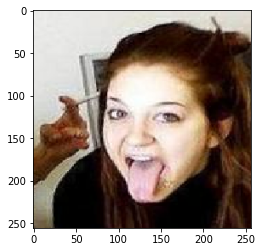

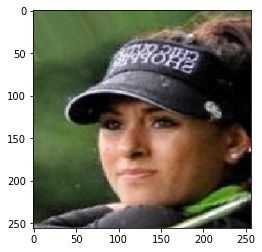

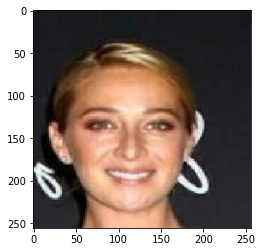

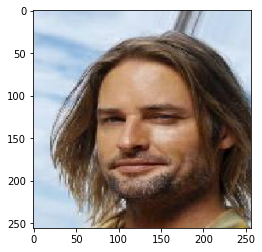

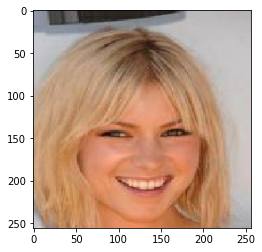

In [10]:
for rf_img in train_real_faces.take(5):
  plt.imshow(rf_img[0,...] * 0.5 + 0.5)
  plt.show()

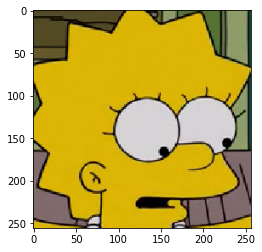

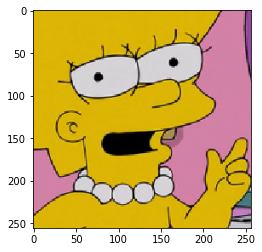

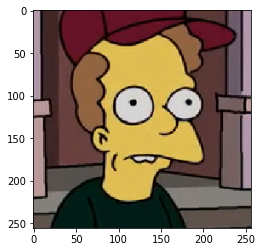

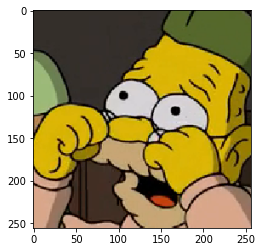

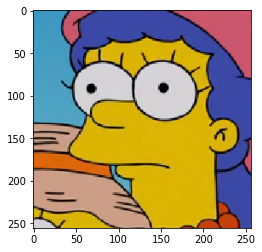

In [11]:
for crt_img in train_cartoons.take(5):
  plt.imshow(crt_img[0,...] * 0.5 + 0.5)
  plt.show()

## Uso de modelos de Pix2Pix

Hacemos uso del generador y discriminador importados del modelo Pix2Pix para crear dos pares generador/discriminador, uno para pasar de cara real a caricatura, y otro para pasar de caricatura a cara real:

In [12]:
sample_real_face = next(iter(train_real_faces))
sample_cartoon = next(iter(train_cartoons))

In [13]:
# Generadores y discriminadores importados

OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Comprobamos el funcionamiento de los generadores con dos imágenes de muestra:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


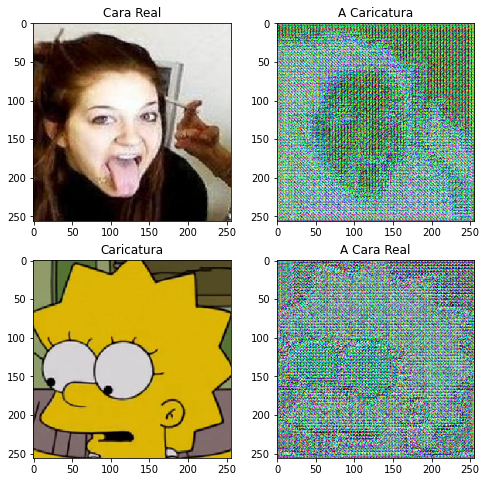

In [14]:
to_cartoon = generator_g(sample_real_face)
to_real_face = generator_f(sample_cartoon)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_real_face, to_cartoon, sample_cartoon, to_real_face]
title = ['Cara Real', 'A Caricatura', 'Caricatura', 'A Cara Real']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

## Función de error

En CycleGAN, debido a que el aprendizaje es no supervisado, se debe tener en consideración el parecido de una imagen de entrada con el resultado de aplicar el cambio de estilo y consecutivamente el cambio de estilo inverso.

También debemos considerar la diferencia entre una imagen de entrada cuyo estilo pertenece a aquel que se le pretende transferir, y el resultado de dicha transferencia:

In [15]:
LAMBDA = 10

In [16]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
# Funciones de error

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5


def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)


def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1


def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Además, inicializamos las entidades encargadas de llevar a cabo el proceso de optimización de la red:

In [18]:
# Optimizadores

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Puntos de guardado

Debido a las limitaciones de la herramienta de Google Collab, necesitamos definir una forma de conservar y recuperar el progreso realizado en el entrenamiento de la red:

In [19]:
# Sistema de checkpoint

# checkpoint_path = PATH + "/checkpoint"    # Ruta del checkpoint con más epochs
checkpoint_path = PATH + "/checkpoint2"   # Ruta del checkpoint con menos epochs

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

## Entrenamiento

Tan solo nos quedan por definir todos los procesos necesarios para el entrenamiento de la red:

In [20]:
EPOCHS = 200

In [21]:
# Entrenamiento

def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Imagen Input', 'Imagen Predicha']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [22]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [24]:
# Si ya hay checkpoint, se recupera el más reciente.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Checkpoint recuperado!!')

Checkpoint recuperado!!


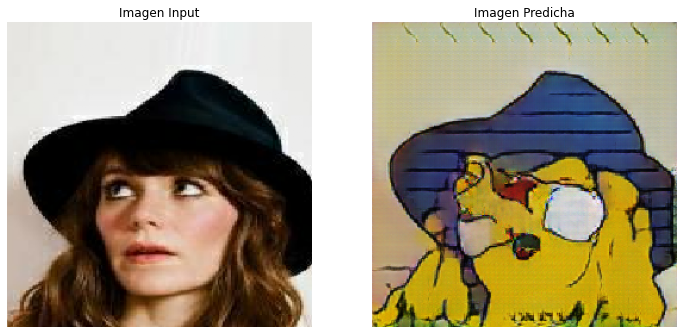

Tiempo transcurrido para el epoch 3 es 1255.1792585849762 seg

.

KeyboardInterrupt: ignored

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_real_faces, train_cartoons)):
    train_step(image_x, image_y)
    if n % 1000 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Usamos la misma imagen (sample_real_face) para visualizar la mejora del modelo
  generate_images(generator_g, sample_real_face)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Guardando checpoint del epoch {} en {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Tiempo transcurrido para el epoch {} es {} seg\n'.format(epoch + 1,
                                                      time.time()-start))

## Comprobación de resultados

Habiendo finalizado el entrenamiento, procedemos a aplicar la red a una serie de imágenes de muestra, procedentes de los dos datasets:

In [24]:
# Probar el modelo entrenado con el conjunto de test
for rf_img in test_real_faces.take(9):
  generate_images(generator_g, rf_img)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
for crt_img in test_cartoons.take(9):
  generate_images(generator_f, crt_img)

Output hidden; open in https://colab.research.google.com to view.